Found 1832 images belonging to 6 classes.
87910968/87910968 [==============================] - 3s 0us/step
Found 1832 images belonging to 6 classes.
58/58 [==============================] - 713s 12s/step - loss: 2.6526 - accuracy: 0.1294
Test accuracy: 0.12936681509017944
Epoch 1/10
58/58 [==============================] - 1159s 20s/step - loss: 32.1943 - accuracy: 0.5671 - val_loss: 0.7643 - val_accuracy: 0.8974
Epoch 2/10
58/58 [==============================] - 1166s 20s/step - loss: 0.6920 - accuracy: 0.8952 - val_loss: 0.1708 - val_accuracy: 0.9602
Epoch 3/10
58/58 [==============================] - 1152s 20s/step - loss: 0.2151 - accuracy: 0.9591 - val_loss: 0.3509 - val_accuracy: 0.9378
Epoch 4/10
58/58 [==============================] - 1150s 20s/step - loss: 0.2815 - accuracy: 0.9476 - val_loss: 0.0608 - val_accuracy: 0.9809
Epoch 5/10
58/58 [==============================] - 1166s 20s/step - loss: 0.2978 - accuracy: 0.9405 - val_loss: 0.0320 - val_accuracy: 0.9913
Epoch 6/10


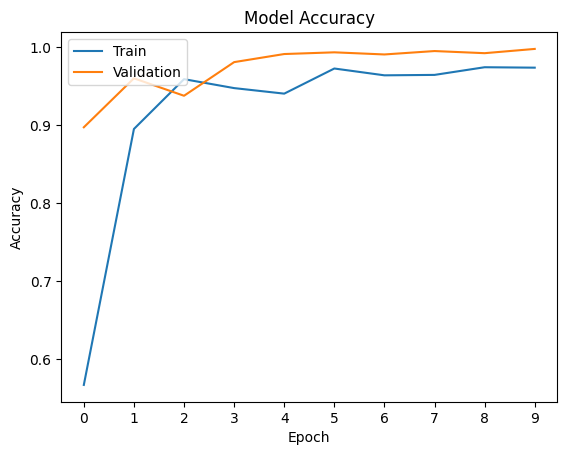

Loss: 0.004774113185703754


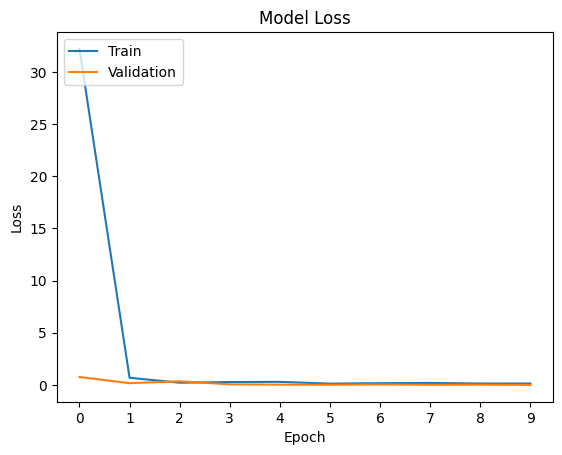

Weights shape: (380,)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [4]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, f1_score,log_loss

# Set the path to your dataset
train_dir = '/data/dataset'
test_dir = '/data/dataset'

# Set the image size and batch size
img_size = (299, 299)
batch_size = 32

# Create a data generator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add a new classification layer
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

# Combine the base model and classification layer
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

labels = ['Foi_Thong', 'Hang_Kra_Rog_Phu_Phan_ST1', 'Hang_Suea_Sakonnakhon_TT1', 'Kroeng_Krawia', 'Tanao_Si_Kan_Khaw_WA1', 'Tanao_Si_Kan_Dang_RD1']
# Train the model and record validation loss and accuracy after each epoch
history = model.fit(train_generator, epochs=10, validation_data=test_generator)


# Save the model
model.save('/code/model/InceptionV3.h5')

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

print("\n")

# Generate predictions for the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Calculate the confusion matrix and print it
confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
print("Confusion Matrix:\n",confusion_matrix)

num_classes = len(labels)
# Calculate TP, FP, TN, and FN for each class
total_TP, total_FP, total_TN, total_FN = 0, 0, 0, 0
class_losses = []
for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    TN = np.sum(confusion_matrix) - TP - FP - FN
    total_TP += TP
    total_FP += FP
    total_TN += TN
    total_FN += FN
    class_loss = log_loss(test_generator.classes == i, Y_pred[:, i])
    class_losses.append(class_loss)
    print(f"\nClass {i} ({labels[i]}):")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"Loss: {class_loss:.3f}")

# Calculate overall accuracy, precision, recall, f1-score, and loss
overall_accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_TN + total_FN)
overall_precision = total_TP / (total_TP + total_FP)
overall_recall = total_TP / (total_TP + total_FN)
overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall)
overall_loss = log_loss(test_generator.classes, Y_pred)

print("\nOverall Performance:")
print(f"Accuracy: {overall_accuracy:.3f}")
print(f"Precision: {overall_precision:.3f}")
print(f"Recall: {overall_recall:.3f}")
print(f"F1-score: {overall_f1:.3f}")
print(f"Loss: {overall_loss:.3f}")

print("\nClass-specific Performance:")
# Calculate precision, recall, f1-score, and loss for each class
for i, label in enumerate(labels):
    class_accuracy = (confusion_matrix[i, i] + np.sum(confusion_matrix) - np.sum(confusion_matrix[i, :]) - np.sum(confusion_matrix[:, i]) + confusion_matrix[i, i]) / np.sum(confusion_matrix)
    class_precision = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
    class_recall = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])
    class_f1 = 2 * class_precision * class_recall / (class_precision + class_recall)
    class_loss = class_losses[i]
    print(f"\nClass {i} ({label}) Performance:")
    print(f"Accuracy: {class_accuracy:.3f}")
    print(f"Precision: {class_precision:.3f}")
    print(f"Recall: {class_recall:.3f}")
    print(f"F1-score: {class_f1:.3f}")
    print(f"Loss: {class_loss:.3f}")
    print("\n")

print("\n")
print("InceptionV3")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
print('Accuracy:', test_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(len(history.history['accuracy'])))
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
print('Loss:', test_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(len(history.history['loss'])))
plt.show()

# Get the weights and biases of the model
weights= model.get_weights()

# Print the shape of the weights and biases
print("Weights shape:", np.shape(weights))
# print("Biases shape:", np.shape(biases))


In [ ]:
# Use the model to make predictions on new images
import matplotlib.pyplot as plt
import tensorflow.keras as keras

#figure 1
new_img = tf.keras.preprocessing.image.load_img('/data/test/test1.jpg', target_size=img_size)

plt.imshow(new_img)
plt.show()

new_img = tf.keras.preprocessing.image.img_to_array(new_img)
#print(new_img)
new_img = new_img / 255.0
new_img = tf.expand_dims(new_img, 0)

prediction = model.predict(new_img)
class_index = tf.argmax(prediction, axis=1)

print('\n')
predicted_label = labels[class_index[0]]
print('Predicted label:', predicted_label)

prediction_values = {}
for i, label in enumerate(labels):
    prediction_values[label] = round(prediction[0][i], 2)

print('Prediction values:', prediction_values)


1/1 [==============================] - 0s 137ms/step


Predicted label: Hang_Kra_Rog_Phu_Phan_ST1
Prediction values: {'Foi_Thong': 0.01, 'Hang_Kra_Rog_Phu_Phan_ST1': 0.98, 'Hang_Suea_Sakonnakhon_TT1': 0.0, 'Kroeng_Krawia': 0.01, 'Tanao_Si_Kan_Khaw_WA1': 0.0, 'Tanao_Si_Kan_Sang_RD1': 0.0}


In [ ]:
print("Model Structure : \n")
model.summary()

Model Structure : 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                         

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 